In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import string
import nltk
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from tensorflow.keras import Model
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM

In [62]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [63]:
from tensorflow import random
random.set_seed(42)

In [64]:
train = pd.read_csv('C:/Users/Donghyeok/Desktop/Work Folder/Reddit Sarcasm Detection/train-balanced-sarcasm.csv')

In [65]:
test = pd.read_csv('C:/Users/Donghyeok/Desktop/Work Folder/Reddit Sarcasm Detection/test-balanced.csv')

In [67]:
train = train.dropna(subset=['comment'])

In [69]:
def remove_punc(comment):
    '''This function uses str methods from the string class to remove punctuation from the text.'''
    
    # replace punctuation with '' (no space)
    translator = str.maketrans('', '', string.punctuation)
    
    # return the text stripped of punctuation marks
    return comment.translate(translator)
train['comment'] = train['comment'].apply(remove_punc)
train.head()

C:\Users\Donghyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,They were underdogs earlier today but since Gr...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,This meme isnt funny none of the new york nigg...,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [70]:
# load stopwords from NLTK
stopwords_eng = stopwords.words('english')
# view stop words
np.array(stopwords_eng)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [71]:
def remove_stopwords_and_lowercase(comment):
    '''This function lowercases words and then remove stopwords.'''
    
    comment = \
    [word.lower() for word in comment.split() if word.lower() not in stopwords_eng]
    return ' '.join(comment)
# Apply the function to each comment
train['comment'] = train['comment'].apply(remove_stopwords_and_lowercase)
train.head()

C:\Users\Donghyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc nh,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,know west teams play west teams east teams right,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,underdogs earlier today since gronks announcem...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,meme isnt funny none new york nigga ones,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,could use one tools,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [45]:
stemmer = SnowballStemmer('english')

def stem_each_word(text):
    '''This function stems each word in `text`'''
    
    text = [stemmer.stem(word) for word in text.split()]
    return ' '.join(text)

# apply stem_each_word function to each TRAIN and TEST comment

# TRAIN
train['comment'] = train['comment'].apply(stem_each_word)
train.head()


C:\Users\Donghyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc nh,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,know west team play west team east team right,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,underdog earlier today sinc gronk announc afte...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,meme isnt funni none new york nigga one,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,could use one tool,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [13]:
lemmatizer = WordNetLemmatizer()

def lemmatize_each_word(text):
    '''This function lemmatizes each word, e.g., 
    - Remove the final "s" or "es" to singularize plurals and change person of some verbs
      (gets --> get,
      passes --> pass, 
      BUT not always as expected: 
      does --> doe (a deer, a female deer), 
      capitalizes --> captializes)
    '''
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(text)

# apply lemmatize_each_word(text) function to each TRAIN and TEST comment

# TRAIN
train['comment'] = train['comment'].apply(lemmatize_each_word)
train.head()

C:\Users\Donghyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc nh,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,know west team play west team east team right,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,underdog earlier today sinc gronk announc afte...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,meme isnt funni none new york nigga one,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,could use one tool,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [46]:
#Choose Random samples (fixed number) and concatenate - Shuffles + sample size:
sample_df_idx1 = np.random.choice(train.loc[train['label']==0].index, int(len(train.loc[train['label']==0].index)*0.5))
sample_df_idx2 = np.random.choice(train.loc[train['label']==1].index, int(len(train.loc[train['label']==1].index)*0.5))
sample_df_idx = np.concatenate((sample_df_idx1, sample_df_idx2))

In [47]:
comments = train['comment'].loc[sample_df_idx]
labels = train['label'].loc[sample_df_idx]

In [40]:
embedding_dim = 32
vocab_size = 8000
length = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(comments)

word_index = tokenizer.word_index

train_seq = tokenizer.texts_to_sequences(comments)
train_pad = pad_sequences(train_seq, maxlen=length, padding='post', truncating='post')

In [41]:
train_seq = np.array(train_seq)
train_pad = np.array(train_pad)
labels = np.array(labels)

C:\Users\Donghyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [43]:
#Holdout validation set
X_train, X_test, y_train, y_test = train_test_split(train_pad, labels, test_size=0.2, random_state=24)


In [49]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=length))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           256000    
_________________________________________________________________
dropout (Dropout)            (None, 100, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               295936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 552,193
Trainable params: 552,193
Non-trainable params: 0
_________________________________________________________________


In [52]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [53]:
checkpoint_path = "training_/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [55]:
num_epochs = 100
batch_size = 95

history = model.fit(X_train, y_train, validation_split=0.2, epochs=num_epochs, batch_size=100, verbose=1, callbacks=[es, cp_callback])


Train on 323446 samples, validate on 80862 samples
Epoch 1/100
323300/323446 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.4993
Epoch 00001: saving model to training_3/cp.ckpt
323446/323446 [==============================] - 133s 413us/sample - loss: 0.6934 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 2/100
323300/323446 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5043
Epoch 00002: saving model to training_3/cp.ckpt
323446/323446 [==============================] - 132s 407us/sample - loss: 0.6932 - accuracy: 0.5043 - val_loss: 0.6776 - val_accuracy: 0.5936
Epoch 3/100
323300/323446 [============================>.] - ETA: 0s - loss: 0.6485 - accuracy: 0.6285
Epoch 00003: saving model to training_3/cp.ckpt
323446/323446 [==============================] - 130s 403us/sample - loss: 0.6485 - accuracy: 0.6285 - val_loss: 0.6153 - val_accuracy: 0.6645
Epoch 4/100
323300/323446 [============================>.] - ETA: 0

Epoch 29/100
323300/323446 [============================>.] - ETA: 0s - loss: 0.5284 - accuracy: 0.7370
Epoch 00029: saving model to training_3/cp.ckpt
323446/323446 [==============================] - 132s 409us/sample - loss: 0.5284 - accuracy: 0.7370 - val_loss: 0.5797 - val_accuracy: 0.6998
Epoch 30/100
323300/323446 [============================>.] - ETA: 0s - loss: 0.5240 - accuracy: 0.7400
Epoch 00030: saving model to training_3/cp.ckpt
323446/323446 [==============================] - 132s 409us/sample - loss: 0.5240 - accuracy: 0.7400 - val_loss: 0.5776 - val_accuracy: 0.7001
Epoch 31/100
323300/323446 [============================>.] - ETA: 0s - loss: 0.5201 - accuracy: 0.7426
Epoch 00031: saving model to training_3/cp.ckpt
323446/323446 [==============================] - 131s 404us/sample - loss: 0.5201 - accuracy: 0.7426 - val_loss: 0.5761 - val_accuracy: 0.7007
Epoch 32/100
323300/323446 [============================>.] - ETA: 0s - loss: 0.5173 - accuracy: 0.7448
Epoch 00032

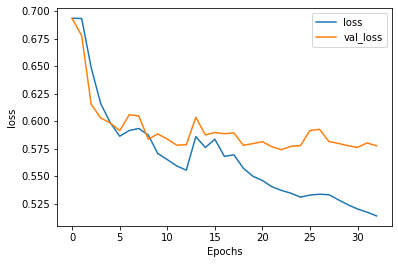

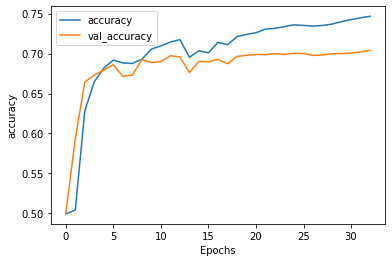

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()
  
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [57]:
model.save('lstm_model_2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: lstm_model_2\assets


In [59]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

101078/1 - 27s - loss: 0.5717 - accuracy: 0.7015
Trained model, accuracy: 70.15%


In [61]:
predictions = model.predict(X_test)

In [62]:
y_pred = predictions > 0.5

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [64]:
matrix = confusion_matrix(y_test, y_pred)

In [65]:
tn, fp, fn, tp = matrix.ravel()

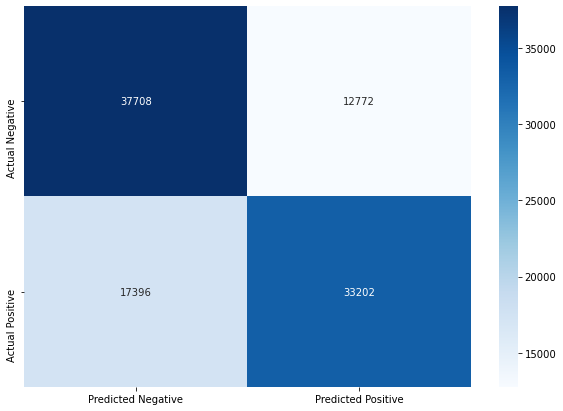

In [66]:
df_cm = pd.DataFrame(matrix, index = ["Actual Negative", "Actual Positive"],
                      columns = ["Predicted Negative", "Predicted Positive"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.75      0.71     50480
           1       0.72      0.66      0.69     50598

    accuracy                           0.70    101078
   macro avg       0.70      0.70      0.70    101078
weighted avg       0.70      0.70      0.70    101078



In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB

In [73]:
X_train, X_test, y_train, y_test = train_test_split(comments, labels)

In [74]:
tfidf_unigram = TfidfVectorizer(ngram_range=(1,1), max_features=50000, min_df=2)
tfidf_bigram = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)

In [75]:
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=24, verbose=1)

In [76]:
tfidf_unigram_pipe = Pipeline([('tfidf_unigram', tfidf_unigram), 
                                 ('logit', logit)])
tfidf_unigram_pipe.fit(X_train, y_train)
uni_val_pred = tfidf_unigram_pipe.predict(X_test)
print("accuracy:", accuracy_score(y_test, uni_val_pred))
print(classification_report(y_test, uni_val_pred))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    7.0s finished


accuracy: 0.680855105384378
              precision    recall  f1-score   support

           0       0.67      0.71      0.69     62808
           1       0.69      0.65      0.67     63539

    accuracy                           0.68    126347
   macro avg       0.68      0.68      0.68    126347
weighted avg       0.68      0.68      0.68    126347



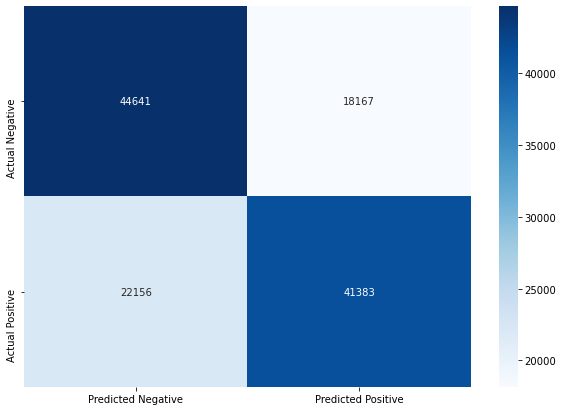

In [77]:
matrix = confusion_matrix(y_test, uni_val_pred)
tn, fp, fn, tp = matrix.ravel()
df_cm = pd.DataFrame(matrix, index = ["Actual Negative", "Actual Positive"],
                      columns = ["Predicted Negative", "Predicted Positive"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")

In [78]:
tfidf_bigram_pipe = Pipeline([('tfidf_bigram', tfidf_bigram), 
                                 ('logit', logit)])
tfidf_bigram_pipe.fit(X_train, y_train)
bi_val_pred = tfidf_bigram_pipe.predict(X_test)
print("accuracy:", accuracy_score(y_test, bi_val_pred))
print(classification_report(y_test, bi_val_pred))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    6.9s finished


accuracy: 0.6996129706285072
              precision    recall  f1-score   support

           0       0.68      0.74      0.71     62808
           1       0.72      0.66      0.69     63539

    accuracy                           0.70    126347
   macro avg       0.70      0.70      0.70    126347
weighted avg       0.70      0.70      0.70    126347



In [79]:
matrix = confusion_matrix(y_test, bi_val_pred)

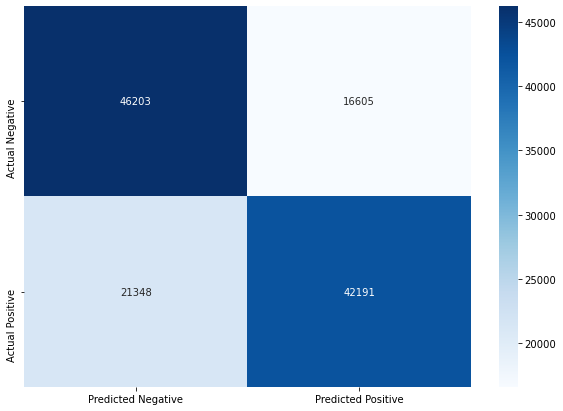

In [80]:
tn, fp, fn, tp = matrix.ravel()
df_cm = pd.DataFrame(matrix, index = ["Actual Negative", "Actual Positive"],
                      columns = ["Predicted Negative", "Predicted Positive"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")

In [81]:
NB = MultinomialNB()

In [82]:
tfidf_unigram_NB_pipe = Pipeline([('tfidf_unigram', tfidf_unigram), 
                                 ('NB', NB)])
tfidf_unigram_NB_pipe.fit(X_train, y_train)
uni_val_NB_pred = tfidf_unigram_NB_pipe.predict(X_test)
print("accuracy:", accuracy_score(y_test, uni_val_NB_pred))
print(classification_report(y_test, uni_val_NB_pred))

accuracy: 0.6728929060444648
              precision    recall  f1-score   support

           0       0.67      0.68      0.68     62808
           1       0.68      0.66      0.67     63539

    accuracy                           0.67    126347
   macro avg       0.67      0.67      0.67    126347
weighted avg       0.67      0.67      0.67    126347



In [83]:
tfidf_bigram_NB_pipe = Pipeline([('tfidf_unigram', tfidf_bigram), 
                                 ('NB', NB)])
tfidf_bigram_NB_pipe.fit(X_train, y_train)
bi_val_NB_pred = tfidf_bigram_NB_pipe.predict(X_test)
print("accuracy:", accuracy_score(y_test, bi_val_NB_pred))
print(classification_report(y_test, bi_val_NB_pred))

accuracy: 0.6902261232953691
              precision    recall  f1-score   support

           0       0.67      0.73      0.70     62808
           1       0.71      0.65      0.68     63539

    accuracy                           0.69    126347
   macro avg       0.69      0.69      0.69    126347
weighted avg       0.69      0.69      0.69    126347



In [84]:
print(classification_report(y_test, bi_val_NB_pred))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70     62808
           1       0.71      0.65      0.68     63539

    accuracy                           0.69    126347
   macro avg       0.69      0.69      0.69    126347
weighted avg       0.69      0.69      0.69    126347

